In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import csv
from nltk.tag import pos_tag # for proper noun
from nltk.tokenize import word_tokenize, sent_tokenize
from statistics import median
import math
from copy import deepcopy
import os
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import seaborn as sns

import statistics


from IPython.display import clear_output

# AMI Corpus

In [2]:
path='path_to_ami\\ami-transcripts'
filelist=os.listdir(path)
transcripts={}
for file in filelist:
    with open(f'{path}\\{file}', 'r') as f: 
        txt=f.read()
        transcripts[file.split('.')[0]]=txt

path='path_to_ami\\ami-summary\\extractive'
filelist=os.listdir(path)       
extractive_summary={}
for file in filelist:
    with open(f'{path}\\{file}', 'r') as f: 
        txt=f.read()
        extractive_summary[file.split('.')[0]]=txt 
        
path='path_to_ami\\ami-summary\\abstractive'
filelist=os.listdir(path)       
abstractive_summary={}
for file in filelist:
    with open(f'{path}\\{file}', 'r') as f: 
        txt=f.read()
        abstractive_summary[file.split('.')[0]]=txt

        
inner_join_transcripts=deepcopy(transcripts)
inner_join_extractive_summary=deepcopy(extractive_summary)
inner_join_abstractive_summary=deepcopy(abstractive_summary)
l=list(transcripts.keys())

for i in l:
    if i not in inner_join_abstractive_summary:
        del inner_join_transcripts[i]
        if i in inner_join_extractive_summary:
            del inner_join_extractive_summary[i]
        continue
    if i not in inner_join_extractive_summary:
        del inner_join_transcripts[i]
        if i in inner_join_abstractive_summary:
            del inner_join_abstractive_summary[i]

In [3]:
def ami_mean(transcripts, small_threshold , big_threshold ):
    stopWords = list(set(stopwords.words("english")))
    count_small=0
    count_big=0
    sum_small=0
    sum_big=0
    position_small=[]
    position_big=[]
    total_sent=0
    total_words=0
    total_refined_words=0
    unique={}
    number=len(transcripts)
    total_unique_refined_words=0
    max_len=[]
    position_max_len=[]
    small_bool=[]
    turns=0
    for key in transcripts.keys():
        txt=nltk.sent_tokenize(transcripts[key])
        total_sent+=len(txt)
        m=0
        p=0
        for index,sentence in enumerate(txt):
            temp=nltk.word_tokenize(sentence)
            sen_len=len(temp)
            m=max(m,sen_len)
            if m==sen_len:
                p=index/len(txt)
            temp=[word.lower() for word in temp]
            word_tokens_refined=[x for x in temp if x not in stopWords]
            for word in word_tokens_refined:
                if word not in unique: 
                    total_unique_refined_words+=1
                    unique[word]=1
                elif word in unique:
                    unique[word]+=1

            total_refined_words+=len(word_tokens_refined)
            total_words+=sen_len
            
            if sen_len<small_threshold:
                count_small+=1
                sum_small+=sen_len
                position_small.append(index/len(txt))
                small_bool.append(1)
            elif sen_len>big_threshold:
                count_big+=1
                sum_big+=sen_len
                position_big.append(index/len(txt))
                small_bool.append(0)
            else:
                small_bool.append(0)
                
        max_len.append(m)
        position_max_len.append(p)

    # number of continuous occurances
    small_cont=0
    check=False
    for i in range(0,len(small_bool),4):
        if sum(small_bool[i:i+4])>=2:
            small_cont+=1
            check=False
        else:
            try: 
                if sum(small_bool[i:i+4])==1 and small_bool[i+3]==1:
                    check=True
                elif sum(small_bool[i:i+4])==1 and small_bool[i]==1 and check==True:
                    small_cont+=1
                    check=False            
            except:
                pass

    
    
    return (count_small, count_big, sum_small, sum_big, position_small, position_big, 
total_sent, total_words, total_refined_words, total_unique_refined_words, unique, number, max_len,
            position_max_len, small_cont)

In [4]:
(count_small_transcripts_ami, count_big_transcripts_ami, sum_small_transcripts_ami, 
sum_big_transcripts_ami, position_small_transcripts_ami, position_big_transcripts_ami, 
total_sent_transcripts_ami, total_words_transcripts_ami, total_refined_words_transcripts_ami,
total_refined_unique_words_transcripts_ami, unique_dict_transcripts_ami, number_transcripts_ami,
max_len_transcripts_ami, position_max_len_transcripts_ami, small_cont_transcripts_ami) = ami_mean(transcripts, 5 , 10)

In [5]:
total_refined_words_transcripts_ami/number_transcripts_ami

4014.497076023392

In [6]:
(count_small_esum_ami, count_big_esum_ami, sum_small_esum_ami, 
sum_big_esum_ami, position_small_esum_ami, position_big_esum_ami, 
total_sent_esum_ami, total_words_esum_ami, total_refined_words_esum_ami,
total_refined_unique_words_esum_ami, unique_dict_esum_ami,number_esum_ami,
max_len_esum_ami, position_max_len_esum_ami,small_cont_esum_ami)  = ami_mean(extractive_summary, 5 , 10)

In [7]:
(count_small_asum_ami, count_big_asum_ami, sum_small_asum_ami, 
sum_big_asum_ami, position_small_asum_ami, position_big_asum_ami, 
total_sent_asum_ami, total_words_asum_ami, total_refined_words_asum_ami,
total_refined_unique_words_asum_ami, unique_dict_asum_ami,number_asum_ami,
max_len_asum_ami, position_max_len_asum_ami,small_cont_asum_ami) = ami_mean(abstractive_summary, 5 , 10)

In [8]:
total_words_asum_ami/len(abstractive_summary)

179.2887323943662

In [9]:
total_sent_asum_ami/number_asum_ami

8.471830985915492

In [10]:
# number of hours:
ami_hours=100  #from their website


In [11]:
path='parth_to_ami\\ami-transcripts-speaker'
filelist=os.listdir(path)
ami_turns=[]
for key in transcripts.keys():
    speakers=[0]*len(transcripts[key].split('.'))
    for file in filelist:
        if file.split('.')[0]==key:
            name=file.split('.')[1]
            with open(f'{path}\\{file}', 'r') as f: 
                txt=f.read()
            for index,line in enumerate(transcripts[key].split('.')):
                if line in txt:
                    speakers[index]=name
    t=0
    for index in range(1,len(speakers)):
        if speakers[index-1]!=speakers[index]:
            t+=1
    ami_turns.append(t)

# ICSI Dataset 

In [12]:
path='path_to_icsi\\transcripts'
temp=os.listdir(path)
root_list=[]
meeting_name_list=[]
text_list=[]
time_list=[]
participants_count_list=[]
turns=[]

path1='path_to_icsi\\Summarization\\abstractive'
absumfilelist=os.listdir(path1)

filelist=[]
for file in absumfilelist:
    if f'{file[:-12]}.mrt' in temp:
        filelist.append(f'{file[:-12]}.mrt')


for file in filelist:
    if file[-3:]=='mrt':
        tree = ET.parse(f'{path}/{file}')
        root = tree.getroot()
        root_list.append(root)
        meeting_name=root.attrib['Session']
        meeting_name_list.append(meeting_name)
        time = float(root[1].attrib['EndTime'])-float(root[1].attrib['StartTime'])
        time_list.append(time)
        # number of speakers
        for index,child in enumerate(root[0]):
            if child.tag=='Participants':
                participants_count_list.append(len(root[0][index].getchildren()))
        
        txt=[]
        t=0

        for child in root[1]:
            try:
                current_speaker=child.attrib['Participant']
                break
            except:
                continue
        for child in root[1]:
            try:
                new_speaker=child.attrib['Participant']
            except:
                pass
            if current_speaker!=new_speaker:
                t+=1
                current_speaker=new_speaker
            txt.append(child.text)
        text_list.append(txt)
        turns.append(t)
        
ab_sumroot_list=[]
ab_sumtext_list=[]
for f in absumfilelist:
    tree = ET.parse(f'{path1}/{f}')
    root = tree.getroot()
    ab_sumroot_list.append(root)
    txt=[]
    s=[]
    for child in ab_sumroot_list[0]:
        for i in child:
            txt.append(i.text)
    ab_sumtext_list.append(txt)

<ipython-input-12-7f80e797a5c7>:31: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  participants_count_list.append(len(root[0][index].getchildren()))


In [ ]:
len(turns)

In [ ]:
icsi_hours=sum(time_list)/3600

In [13]:
def icsi_mean(text_list,small_threshold, big_threshold):
    stopWords = list(set(stopwords.words("english")))
    count_small=0
    count_big=0
    sum_small=0
    sum_big=0
    position_small=[]
    position_big=[]
    total_sent=0
    total_words=0
    total_refined_words=0
    unique={}
    total_unique_refined_words=0
    number=len(text_list)
    
    max_len=[]
    position_max_len=[]
    
    small_bool=[]
    for i in range(len(text_list)):
        # index of one document 
        
        total_sent+=len(text_list[i])
        m=0
        p=0
        #m=max(m,len(text_list[i]))
        #if m==len(text_list[i]):
        #    p=i/
        for index,text in enumerate(text_list[i]):
            
            a=nltk.word_tokenize(text)
            m=max(m,len(a))
            if m==len(a):
                p=index/len(text_list[i])
            a=[word.lower() for word in a]
            word_tokens_refined=[x for x in a if x not in stopWords]
            for word in word_tokens_refined:
                if word not in unique: 
                    total_unique_refined_words+=1
                    unique[word]=1
                elif word in unique:
                    unique[word]+=1
            total_refined_words+=len(word_tokens_refined)
            total_words+=len(a)
            
            if len(a)<small_threshold:
                count_small+=1
                sum_small+=len(a)
                position_small.append(index/len(text_list[i]))
                small_bool.append(1)
            elif len(a)>big_threshold:
                count_big+=1
                sum_big+=len(a)
                position_big.append(index/len(text_list[i]))
                small_bool.append(0)
            else:
                small_bool.append(0)
            max_len.append(m)
            position_max_len.append(p)
     
    small_cont=0
    check=False
    for i in range(0,len(small_bool),4):
        if sum(small_bool[i:i+4])>=2:
            small_cont+=1
            check=False
        else:
            try:
                if sum(small_bool[i:i+4])==1 and small_bool[i+3]==1:
                    check=True
                elif sum(small_bool[i:i+4])==1 and small_bool[i]==1 and check==True:
                    small_cont+=1
                    check=False  
            except:
                pass

                
    return (count_small, count_big, sum_small, sum_big, position_small, position_big, total_sent,total_words,
total_refined_words, total_unique_refined_words, unique, number, max_len, position_max_len, small_cont)

In [14]:
(count_small_transcripts_icsi, count_big_transcripts_icsi, sum_small_transcripts_icsi,
sum_big_transcripts_icsi, position_small_transcripts_icsi, position_big_transcripts_icsi,
total_sent_transcripts_icsi,total_words_transcripts_icsi, total_refined_words_transcripts_icsi, 
total_refined_unique_words_transcripts_icsi, unique_dict_transcripts_icsi, number_transcripts_icsi, 
max_len_transcripts_icsi, position_max_len_transcripts_icsi, small_cont_transcripts_icsi)=icsi_mean(text_list,5,10)

In [ ]:
total_refined_words_transcripts_icsi/number_transcripts_icsi

In [15]:
(count_small_asum_icsi, count_big_asum_icsi, sum_small_asum_icsi,
sum_big_asum_icsi, position_small_asum_icsi, position_big_asum_icsi,
total_sent_asum_icsi,total_words_asum_icsi, total_refined_words_asum_icsi, 
total_refined_unique_words_asum_icsi, unique_dict_asum_icsi, number_asum_icsi,
max_len_asum_icsi, position_max_len_asum_icsi, small_count_asum_icsi)=icsi_mean(ab_sumtext_list,5,10)

In [ ]:
total_refined_words_asum_icsi/number_asum_icsi

# AutoMin 

In [16]:
path='path_to_automn\\deidentified-meetings'
filelist=os.listdir(path)

automin_transcripts={}
automin_summary={}
participants={}
for file in filelist:
    summs={}
    #if file[-2:]=='en':
    f=os.listdir(f'{path}\\{file}')
    for ts in f:
        if ts[-4:]!='.txt':
            continue
        #print(ts[:7])

        if ts[:10]=='transcript':
            name=list(ts.split('_'))[2][:8]
            with open(f'{path}\\{file}\\{ts}', 'r', encoding='utf8') as f1:
                txt=f1.read()
                automin_transcripts[file]=txt

        if ts[:7]=='minutes':
            #print(ts[:7])
            name=''.join(list(ts.split('.'))[-3])
            with open(f'{path}\\{file}\\{ts}', 'r', encoding='utf8') as f2:
                txt=f2.read()
                summs[name]=txt
    automin_summary[file]=summs
                    

In [ ]:
len(automin_transcripts)

In [17]:
(count_small_transcripts_automin, count_big_transcripts_automin, sum_small_transcripts_automin, 
sum_big_transcripts_automin, position_small_transcripts_automin, position_big_transcripts_automin, 
total_sent_transcripts_automin, total_words_transcripts_automin, total_refined_words_transcripts_automin,
total_refined_unique_words_transcripts_automin, unique_dict_transcripts_automin, number_transcripts_automin,
max_len_transcripts_automin, position_max_len_transcripts_automin, small_cont_transcripts_automin) = ami_mean(automin_transcripts, 5 , 10)

In [18]:
count_small_asum_automin=[]
count_big_asum_automin=[]
sum_small_asum_automin=[]
sum_big_asum_automin=[]
position_small_asum_automin=[]
position_big_asum_automin=[]
total_sent_asum_automin=[]
total_words_asum_automin=[]
total_refined_words_asum_automin=[]
total_refined_unique_words_asum_automin=[]
unique_dict_asum_automin=[]
number_asum_automin=[]
max_len_asum_automin=[]
position_max_len_asum_automin=[]
small_cont_asum_automin=[]

ll=[count_small_asum_automin, count_big_asum_automin, sum_small_asum_automin, 
sum_big_asum_automin, position_small_asum_automin, position_big_asum_automin, 
total_sent_asum_automin, total_words_asum_automin, total_refined_words_asum_automin,
total_refined_unique_words_asum_automin, unique_dict_asum_automin, number_asum_automin,
max_len_asum_automin, position_max_len_asum_automin, small_cont_asum_automin]

for key in automin_summary.keys():
    temp=ami_mean(automin_summary[key], 5,10)
    for index in range(len(temp)):
        ll[index].append(temp[index])
    
count_small_asum_automin=sum(count_small_asum_automin)
count_big_asum_automin=sum(count_big_asum_automin)
sum_small_asum_automin=sum(sum_small_asum_automin)
sum_big_asum_automin=sum(sum_big_asum_automin)
position_small_asum_automin=sum(position_small_asum_automin,[])
position_big_asum_automin=sum(position_big_asum_automin,[])
total_sent_asum_automin=sum(total_sent_asum_automin)
total_words_asum_automin=sum(total_words_asum_automin)
total_refined_words_asum_automin=sum(total_refined_words_asum_automin)
total_refined_unique_words_asum_automin=sum(total_refined_unique_words_asum_automin)
number_asum_automin=sum(number_asum_automin)
max_len_asum_automin=sum(max_len_asum_automin,[])
position_max_len_asum_automin=sum(position_max_len_asum_automin,[])
small_cont_asum_automin=sum(small_cont_asum_automin)



# (count_small_asum_automin, count_big_asum_automin, sum_small_asum_automin, 
# sum_big_asum_automin, position_small_asum_automin, position_big_asum_automin, 
# total_sent_asum_automin, total_words_asum_automin, total_refined_words_asum_automin,
# total_refined_unique_words_asum_automin, unique_dict_asum_automin, number_asum_automin,
# max_len_asum_automin, position_max_len_asum_automin, small_cont_asum_automin) = ami_mean(automin_summary, 5 , 10)

# AMI Turns and number of speakers (using change in speaker) 

In [19]:
turns_list=[]
speaker_list=[]

for key in automin_transcripts.keys():
    s=[]
    check=False
    turns=0
    speaker=[]
    for index,i in enumerate(automin_transcripts[key]):
        if check == True:
            s.append(i)
        if i=='(' and automin_transcripts[key][index+1:index+7]=='PERSON':
            turns+=1
            check=True
        if i==')' and check == True:
            check=False
            speaker.append(''.join(s[:-1]))
            s=[]
    turns_list.append(turns)
    speaker_list.append(list(set(speaker)))


In [ ]:
# number of speakers

len(sum(speaker_list, []))/ len(speaker_list)

In [ ]:
# turns

sum(turns_list)/len(turns_list)

# Dataframe 

In [20]:
df=pd.DataFrame(columns=['count_small', 'count_big','sum_small','sum_big','position_small','position_big',
    'total_sent','total_words','total_refined_words','total_unique_refined_words','number','unique','max_len',
                         'position_max_len','small_cont_percentage','dataset', 'label'],
                index=['ami_transcripts', 'ami_esum', 'ami_asum','icsi_transcripts', 'icsi_asum','automin_transcripts', 'automin_asum'])
df.count_small=[count_small_transcripts_ami, count_small_esum_ami, count_small_asum_ami,count_small_transcripts_icsi,count_small_asum_icsi, count_small_transcripts_automin, count_small_asum_automin]
df.count_big=[count_big_transcripts_ami, count_big_esum_ami, count_big_asum_ami,count_big_transcripts_icsi, count_big_asum_icsi, count_big_transcripts_automin, count_big_asum_automin]
df.sum_small=[sum_small_transcripts_ami, sum_small_esum_ami, sum_small_asum_ami, sum_small_transcripts_icsi,sum_small_asum_icsi, sum_small_transcripts_automin, sum_small_asum_automin]
df.sum_big=[sum_big_transcripts_ami,sum_big_esum_ami, sum_big_asum_ami, sum_big_transcripts_icsi, sum_big_asum_icsi, sum_big_transcripts_automin, sum_big_asum_automin]
df.position_small=[position_small_transcripts_ami,position_small_esum_ami, position_small_asum_ami, position_small_transcripts_icsi, position_small_asum_icsi, position_small_transcripts_automin, position_small_asum_automin]
df.position_big=[position_big_transcripts_ami,position_big_esum_ami, position_big_asum_ami, position_big_transcripts_icsi, position_big_asum_icsi, position_big_transcripts_automin, position_big_asum_automin]
df.total_sent=[total_sent_transcripts_ami, total_sent_esum_ami, total_sent_asum_ami, total_sent_transcripts_icsi, total_sent_asum_icsi, total_sent_transcripts_automin, total_sent_asum_automin]
df.total_words=[total_words_transcripts_ami,total_words_esum_ami,total_words_asum_ami, total_words_transcripts_icsi, total_words_asum_icsi, total_words_transcripts_automin, total_words_asum_automin]
df.total_refined_words=[total_refined_words_transcripts_ami, total_refined_words_esum_ami, total_refined_words_asum_ami, total_refined_words_transcripts_icsi, total_refined_words_asum_icsi, total_refined_words_transcripts_automin, total_refined_words_asum_automin]
df.total_unique_refined_words=[total_refined_unique_words_transcripts_ami, total_refined_unique_words_esum_ami, total_refined_unique_words_asum_ami, total_refined_unique_words_transcripts_icsi, total_refined_unique_words_asum_icsi, total_refined_unique_words_transcripts_ami, total_refined_unique_words_asum_automin]
df.number=[number_transcripts_ami,number_esum_ami, number_asum_ami, number_transcripts_icsi, number_asum_icsi, number_transcripts_automin, number_asum_automin]
df.unique=[unique_dict_transcripts_ami, unique_dict_esum_ami, unique_dict_asum_ami, unique_dict_transcripts_icsi, unique_dict_asum_icsi, unique_dict_transcripts_automin, unique_dict_asum_automin]
df.max_len=[max_len_transcripts_ami, max_len_esum_ami, max_len_asum_ami,max_len_transcripts_icsi,max_len_asum_icsi, max_len_transcripts_automin, max_len_asum_automin]
df.position_max_len=[position_max_len_transcripts_ami, position_max_len_esum_ami, position_max_len_asum_ami,position_max_len_transcripts_icsi,position_max_len_asum_icsi, position_max_len_transcripts_automin, position_max_len_asum_automin]
df.small_cont_percentage=[small_cont_transcripts_ami/total_sent_transcripts_ami, small_cont_esum_ami/total_sent_esum_ami, small_cont_asum_ami/total_sent_asum_ami,small_cont_transcripts_icsi/total_sent_transcripts_icsi, small_count_asum_icsi/total_sent_asum_icsi, small_cont_transcripts_automin/total_sent_transcripts_automin, small_cont_asum_automin/total_sent_asum_automin]

df.dataset=['ami', 'ami','ami', 'icsi', 'icsi','automin', 'automin']
df.label=['transcript', 'extractive_summary', 'abstractive_summary','transcript', 'abstractive_summary','transcript', 'abstractive_summary']

In [21]:
# convert list of automin unique words to dict
original_automin_vocabs=deepcopy(df['unique']['automin_asum'])
t={}
for dic in df['unique']['automin_asum']:
    for key in dic:
        if key in t:
            t[key]+=dic[key]
        else:
            t[key]=dic[key]
df['unique']['automin_asum']=t

<ipython-input-21-ae695f6ac165>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unique']['automin_asum']=t


In [ ]:
df

### Novel summary words 

In [22]:
def novel_summ_word(df, dataset):
    t=0
    for i in df['unique'][f'{dataset}_asum'].keys():
        if i not in df['unique'][f'{dataset}_transcripts'].keys():
            t+=1
            
    return t, t/len(df.unique[f'{dataset}_asum'])

In [ ]:
len(df.unique.ami_asum)

In [ ]:
novel_summ_word(df, 'ami')

In [ ]:
novel_summ_word(df, 'icsi')

In [ ]:
novel_summ_word(df,'automin')

### Distribution of small sentences in datasets 

In [ ]:
sns.kdeplot(df.position_small.loc['ami_transcripts'])
sns.kdeplot(df.position_small.loc['icsi_transcripts'])
sns.kdeplot(df.position_small.loc['automin_transcripts'])

### Distribution of big sentences in datasets 

In [ ]:
sns.kdeplot(df.position_big.loc['ami_transcripts'])
sns.kdeplot(df.position_big.loc['icsi_transcripts'])
sns.kdeplot(df.position_big.loc['automin_transcripts'])

### Total sentences 

In [ ]:
sns.barplot(x=df.label,y=df.total_sent, hue=df.dataset, palette='Blues')

### Total words 

In [ ]:
sns.barplot(x=df.label,y=df.total_words, hue=df.dataset, palette='Blues')

### Total refined words  (occurance)

In [ ]:
sns.barplot(x=df.label,y=df.total_refined_words, hue=df.dataset, palette='Blues')

### Total unique refined words  (Vocabulary)

In [ ]:
sns.barplot(x=df.label,y=df.total_unique_refined_words, hue=df.dataset, palette='Blues')

### Frequency of small talk 

In [ ]:
sns.barplot(x=df.label,y=df.count_small, hue=df.dataset, palette='Blues')

### Frequency of big talk 

In [ ]:
sns.barplot(x=df.label,y=df.count_big, hue=df.dataset, palette='Blues')

### Percentage of small talk (sentences) 

In [ ]:
sns.barplot(x=df.label,y=(df.count_small/df.total_sent)*100, hue=df.dataset, palette='Blues')

In [ ]:
df.count_small/df.total_sent*100

### Percentage of big sentences  

In [ ]:
sns.barplot(x=df.label,y=(df.count_big/df.total_sent)*100, hue=df.dataset, palette='Blues')

### Average length 

In [ ]:
sns.barplot(x=df.label,y=(df.total_sent/df.number), hue=df.dataset, palette='Blues')

In [ ]:
df.total_sent/df.number

In [ ]:
df.total_words/df.number

### Max sentence length 

In [ ]:
df.max_len.apply(sum)/df.max_len.apply(len)

In [ ]:
len(df.position_small.automin_transcripts)

### T-test 

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
ttest_ind(df.position_big.icsi_transcripts,df.position_big.automin_transcripts)

In [ ]:
ttest_ind(df.position_big.ami_transcripts,df.position_big.automin_transcripts)

# LDA  

In [23]:
import spacy
from gensim import corpora
import gensim

spacy.load('en')
from spacy.lang.en import English
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

def prepare_text_for_lda(text):
    tokens = tokenize(text)
#     tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\umang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\umang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
#ami 
scores=0
for key in transcripts.keys():
    clear_output(wait=True)
    print(key,".......................", end=" ")
    text_data = []
    for line in nltk.sent_tokenize(transcripts[key]):
        tokens = prepare_text_for_lda(line)
        if len(tokens)>=1:
            text_data.append(tokens)
    
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=100, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=20)
    a=[]
    for topic in topics:

        s=0
        for i in topic[1].split('+ '):
            s+=float(i[:5])
        a.append(s)
    maxa=max(a)
    a=[i/maxa for i in a if i/maxa>0.5]
    scores+=len(a)
    print(' : done')
print(scores/len(transcripts))

TS3012d .......................  : done
15.421052631578947


In [25]:
#icsi

scores=0
for index in range(len(text_list)):
    text_data = []
    for line in nltk.sent_tokenize(''.join(text_list[index])):
        tokens = prepare_text_for_lda(line)
        # print(tokens)
        if len(tokens)>=1:
            #print(tokens)
            text_data.append(tokens)
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    #pickle.dump(corpus, open('corpus.pkl', 'wb'))
    #dictionary.save('dictionary.gensim')
    ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=100, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=20)
    a=[]
    for topic in topics:
        s=0
        for i in topic[1].split('+ '):
            s+=float(i[:5])
        a.append(s)
    maxa=max(a)
    a=[i/maxa for i in a if i/maxa>0.5]
    scores+=len(a)

    
print(scores/len(text_list))

16.278688524590162


In [26]:
# automin

scores=0
for key in automin_transcripts.keys():
    text_data = []
    for line in nltk.sent_tokenize(automin_transcripts[key]):
        tokens = prepare_text_for_lda(line)
        # print(tokens)
        if len(tokens)>=1:
            #print(tokens)
            text_data.append(tokens)
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    #pickle.dump(corpus, open('corpus.pkl', 'wb'))
    #dictionary.save('dictionary.gensim')
    ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=100, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=20)
    a=[]
    for topic in topics:
        s=0
        for i in topic[1].split('+ '):
            s+=float(i[:5])
        a.append(s)
    maxa=max(a)
    a=[i/maxa for i in a if i/maxa>0.5]
    scores+=len(a)
    
print(scores/len(transcripts))


10.75438596491228


### Correlation 

In [ ]:
from scipy.stats import pearsonr


In [ ]:
def correlation(dataset):
    #normalize score
    t_vocab={}
    for key in df['unique'][f'{dataset}_transcripts'].keys():
        t_vocab[key]=df['unique'][f'{dataset}_transcripts'][key]/len(df['unique'][f'{dataset}_transcripts'])
    print(t_vocab)
    s_vocab={}
    for key in df['unique'][f'{dataset}_asum'].keys():
        s_vocab[key]=df['unique'][f'{dataset}_asum'][key]/len(df['unique'][f'{dataset}_asum'])

    corr=[]
    x=[]
    y=[]
    for key in t_vocab:
        if key in s_vocab:
            x.append(t_vocab[key])
            y.append(s_vocab[key])

    return pearsonr(x,y)[0]

In [ ]:
df['unique'][f'ami_transcripts']

In [ ]:
correlation('ami')

In [ ]:
correlation('icsi')

In [ ]:
correlation('automin')

# Perplexity and Entropy 

In [ ]:
# find number of words spoken by each speaker
# ami
path='path_to_ami\\ami-transcripts-speaker'
filelist=os.listdir(path)
entropy=[]
perplexity=[]
for key in transcripts.keys():
    speaker_words=[]
    for file in filelist:
        if file[:7]==key:
            with open(f'{path}\\{file}','r', encoding='utf8') as f:
                txt=f.read()
                speaker_words.append(len(txt.split(' ')))
        elif file[:6]==key:
            with open(f'{path}\\{file}','r', encoding='utf8') as f:
                txt=f.read()
                speaker_words.append(len(txt.split(' ')))
        else:
            pass
    tot=sum(speaker_words)
    speaker_words=[i/tot for i in speaker_words]
    e=0
    for p in speaker_words:
        e+=(np.log2(p))
    e=e/len(speaker_words)
    entropy.append(e)
    perplexity.append(pow(2,e))
print('AVG Perplexity: ',statistics.mean(perplexity))
print('AVG Entropy: ',statistics.mean(entropy))

In [ ]:
# icsi

speakers={}
entropy=[]
perplexity=[]
for root in root_list:
    
    #getting number of words spoken by speakers
    
    for child in root[1]:
        if 'Participant' in child.attrib:
                #print(len(child.text.split(' ')))
                if child.attrib['Participant'] in speakers:
                    speakers[child.attrib['Participant']]+=len(child.text.split(' '))
                else:
                    speakers[child.attrib['Participant']]=len(child.text.split(' '))
        #print(child)
    
    tot=sum(speakers.values())
    speaker=[i/tot for i in speakers.values()]
    e=0
    for p in speaker:
        e+=(np.log2(p))
    e=e/len(speaker)
    entropy.append(e)
    perplexity.append(pow(2,e))

print('AVG Perplexity: ',statistics.mean(perplexity))
print('AVG Entropy: ',statistics.mean(entropy))

In [ ]:
# automin

entropy=[]
perplexity=[]

for key in automin_transcripts.keys():
    turns=0
    speaker={}
    text=automin_transcripts[key]#.split(' ')
    # get speaker words
    for index,i in enumerate(text):
        
        
        if i=='(' and text[index+1:index+7]=='PERSON':
            name=text[index+1:index+8]
            t=[]
            for index_temp,temp in enumerate(text[(index+10):]):
                if temp=='(':
                    break
                t.append(temp)
            t=len((''.join(t)).split(' '))
            if name in speaker:
                speaker[name]+=t
            else:
                speaker[name]=t
    try:
        tot=sum(speaker.values())
        speaker=[i/tot for i in speaker.values()]
        e=0
        for p in speaker:
            e+=(np.log2(p))
        e=e/len(speaker)
        entropy.append(e)
        perplexity.append(pow(2,e))
    except:
        pass
        #print(key)
                    

print('AVG Perplexity: ',statistics.mean(perplexity))
print('AVG Entropy: ',statistics.mean(entropy))
                    

# Inter Annotator Agreement 

In [27]:
from scipy.stats import chisquare
chisq=[]
standard_deviations=[]
for key1 in automin_summary.keys():
    scores=0
    # For each transcripts' summary
    og=[]
    full_dioc={}    # master dictionary Contains all the keywords with their occurance over all the summaries (for each transcript) 
    dioc=[]         # list of individual dictionaries with occurance score for every keyword in ONE summary. 
    for key in automin_summary[key1].keys():
        text_data = []
        a=[]
        for line in nltk.sent_tokenize(automin_summary[key1][key]):
            tokens = prepare_text_for_lda(line)
            # print(tokens)
            if len(tokens)>=1:
                #print(tokens)
                text_data.append(tokens)
        dictionary = corpora.Dictionary(text_data)
        corpus = [dictionary.doc2bow(text) for text in text_data]
        #pickle.dump(corpus, open('corpus.pkl', 'wb'))
        #dictionary.save('dictionary.gensim')
        ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=10, id2word=dictionary, passes=15)
        topics = ldamodel.print_topics(num_words=10)

        # For each summary.
        topic_list=[]  # keywords
        topc_dic={}    # keywords with occurance score for every summary. 
        for topic in topics:
            #print(topic[1].split('+'))
            for i in topic[1].split('+'):
                a.append(i[7:-1])
                name=i[7:-1]
                if name in dioc:
                    full_dioc[name]+=1
                else:
                    full_dioc[name]=1
                if name in topc_dic:
                    topc_dic[name]+=1
                else:
                    topc_dic[name]=1

            
            topic_list.append(a)
        dioc.append(topc_dic)
        og.append(topic_list)
        
        
    vals=[]
    for i in range(len(dioc)):
        #print(i)
        x_obs=list(dioc[i].values())
        #x_obs=[1]*len(dioc[i])
        y_exp=[]
        for key in dioc[i]:
            if key in full_dioc:
                y_exp.append(full_dioc[key])
            else:
                y_exp.append(0)
        vals.append(chisquare(x_obs,y_exp)[1])
    chisq.append(statistics.median(vals))
    if len(vals)>1:
        standard_deviations.append(statistics.stdev(vals))
    else:
        standard_deviations.append(0)
    

In [30]:
from scipy.stats import pearsonr


In [32]:
# correlation for inter annoator agreement, test  ---------------------------------------------------------------------

chisq=[]
standard_deviations=[]
for key1 in automin_summary.keys():
    scores=0
    # For each transcripts' summary
    og=[]
    full_dioc={}    # master dictionary Contains all the keywords with their occurance over all the summaries (for each transcript) 
    dioc=[]         # list of individual dictionaries with occurance score for every keyword in ONE summary. 
    for key in automin_summary[key1].keys():
        text_data = []
        a=[]
        for line in nltk.sent_tokenize(automin_summary[key1][key]):
            tokens = prepare_text_for_lda(line)
            # print(tokens)
            if len(tokens)>=1:
                #print(tokens)
                text_data.append(tokens)
        dictionary = corpora.Dictionary(text_data)
        corpus = [dictionary.doc2bow(text) for text in text_data]
        #pickle.dump(corpus, open('corpus.pkl', 'wb'))
        #dictionary.save('dictionary.gensim')
        ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=10, id2word=dictionary, passes=15)
        topics = ldamodel.print_topics(num_words=10)

        # For each summary.
        topic_list=[]  # keywords
        topc_dic={}    # keywords with occurance score for every summary. 
        for topic in topics:
            #print(topic[1].split('+'))
            for i in topic[1].split('+'):
                a.append(i[7:-1])
                name=i[7:-1]
                if name in full_dioc:
                    full_dioc[name]+=1
                else:
                    full_dioc[name]=1
                if name in topc_dic:
                    topc_dic[name]+=1
                else:
                    topc_dic[name]=1

            
            topic_list.append(a)
        dioc.append(topc_dic)
        og.append(topic_list)
        
        
    vals=[]
    for i in range(len(dioc)):
        #print(i)
        x_obs=list(dioc[i].values())
        #x_obs=[1]*len(dioc[i])
        y_exp=[]
        for key in dioc[i]:
            if key in full_dioc:
                y_exp.append(full_dioc[key])
            else:
                y_exp.append(0)
        vals.append(pearsonr(x_obs,y_exp)[0])
    chisq.append(statistics.median(vals))
    if len(vals)>1:
        standard_deviations.append(statistics.stdev(vals))
    else:
        standard_deviations.append(0)
    

C:\Users\umang\anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [36]:
statistics.median(chisq)

0.7811294912904847

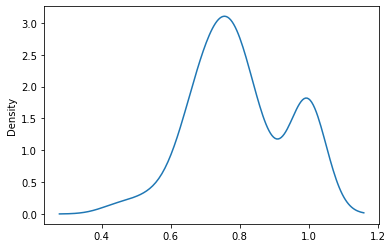

In [38]:
sns.kdeplot(chisq)

In [28]:
print(full_dioc)

{'person1"': 1, '"meeting"': 1, '"person9"': 1, '"attendee"': 1, '"person2"': 1, '"preparation"': 1, '"purpose"': 1, '"2020/05/04"': 1, '"location1"': 1, '"session': 1, 'already"': 1, '"prepare"': 1, '"consecutevely"': 1, '"czech"': 1, '"translate"': 1, '"video"': 1, '"youtube"': 1, '"person1"': 1, '"organization2': 1, 'check"': 1, '"platform"': 1, '"person5"': 1, '"light"': 1, '"conferencing"': 1, '"submit"': 1, '"minutes"': 1, '"annotator2"': 1, '"location1': 1, '"domain"': 1, '"organization2"': 1, '"summary"': 1, '"person"': 1, '"worry"': 1, '"present"': 1, '"romanian"': 1, '"location': 1, 'session"': 1, '"input"': 1, '"person8"': 1, '"german"': 1, '"doodle': 1, 'person8"': 1, '"organization5"': 1, '"choose"': 1, '"chosen"': 1, '"need"': 1, '"session"': 1, 'input"': 1, '"english"': 1, '"arrange"': 1, '"doodle"': 1, '"person9': 1, '"check': 1, '"discus"': 1, '"german': 1, 'location1"': 1, 'project5"': 1, '"project1"': 1, '"subtitle"': 1, '"submit': 1, 'choose"': 1, '"cooperation"': 1

In [ ]:
sns.kdeplot(standard_deviations)

In [ ]:
statistics.median(chisq)

In [ ]:
statistics.mean(chisq)

# Standard Deviation between length of vocabularies of two summaries  

In [ ]:
stopWords = list(set(stopwords.words("english")))
standard_devs=[]
for key1 in automin_summary.keys():
    lens=[]
    for key in automin_summary[key1].keys():
        text_data = []
        a=[]
        vocab={}
        for line in nltk.sent_tokenize(automin_summary[key1][key]):
            words = nltk.word_tokenize(line)
            words=[word.lower() for word in words]
            refined_words=[word for word in words if word not in stopWords]
            for word in refined_words:
                if word in vocab:
                    vocab[word]+=1
                else:
                    vocab[word]=1
            
        lens.append(len(vocab.keys()))
    if len(lens)==1:
        standard_devs.append(0)
    else:
        standard_devs.append(statistics.stdev(lens))


In [ ]:
statistics.mean(standard_devs)

# Similarity between topics in Transcript and summaries 

In [ ]:
def get_jaccard_sim(l1, l2): 
    a = set(l1) 
    b = set(l2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
#ami 
similarity=[]
for key in extractive_summary.keys():
    clear_output(wait=True)
    print(key,".......................", end=" ")
    text_data = []
    for line in nltk.sent_tokenize(transcripts[key]):
        tokens = prepare_text_for_lda(line)

        if len(tokens)>=1:
            text_data.append(tokens)
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]

    ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=10, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=10)
    
    
    t_topic=[]
    for topic in topics:
        temp=[]
        for index in range(1,len(topic[1].split('"')),2):
            temp.append(topic[1].split('"')[index])
        t_topic.append(temp)
    
    text_data=[]
    for line in nltk.sent_tokenize(extractive_summary[key]):
        tokens = prepare_text_for_lda(line)
        if len(tokens)>=1:
            text_data.append(tokens)
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]

    ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=10, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=10)
    
    
    s_topic=[]
    for topic in topics:
        temp=[]
        for index in range(1,len(topic[1].split('"')),2):
            temp.append(topic[1].split('"')[index])
        s_topic.append(temp)
    sim=[]
    for index_t in range(len(t_topic)):
        max_sim=0
        for index_s in range(len(s_topic)):
            max_sim=max(max_sim,get_jaccard_sim(t_topic[index_t], s_topic[index_s]))
        sim.append(max_sim)
    similarity.append(statistics.mean(sim))
    print(' : done')
print('Jaccard similarity between transcript and summary topics: ', statistics.mean(similarity))

In [ ]:
#icsi
similarity=[]
for index in range(len(text_list)):
    clear_output(wait=True)
    print((index/len(text_list))*100,".......................", end=" ")
    text_data = []
    for line in nltk.sent_tokenize(''.join(text_list[index])):
        tokens = prepare_text_for_lda(line)
        if len(tokens)>=1:
            text_data.append(tokens)
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=10, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=10)
    t_topic=[]
    for topic in topics:
        temp=[]
        for index in range(1,len(topic[1].split('"')),2):
            temp.append(topic[1].split('"')[index])
        t_topic.append(temp)
    
    
    text_data=[]
    for line in nltk.sent_tokenize(''.join(ab_sumtext_list[index])):
        tokens = prepare_text_for_lda(line)
        if len(tokens)>=1:
            text_data.append(tokens)
    
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=10, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=10)
    s_topic=[]
    for topic in topics:
        temp=[]
        for index in range(1,len(topic[1].split('"')),2):
            temp.append(topic[1].split('"')[index])
        s_topic.append(temp)
    print(len(t_topic), len(s_topic))
    sim=[]
    for index_t in range(len(t_topic)):
        max_sim=0
        #sim.append(get_jaccard_sim(t_topic[index_t], s_topic[index_t]))
        for index_s in range(len(s_topic)):
            max_sim=max(max_sim,get_jaccard_sim(t_topic[index_t], s_topic[index_s]))
        sim.append(max_sim)
    similarity.append(statistics.mean(sim))
    print(' : done')
print('Jaccard similarity between transcript and summary topics: ', statistics.mean(similarity))  

In [ ]:
#automin

similarity=[]
for key in automin_transcripts.keys():
    clear_output(wait=True)
    print(key,".......................", end=" ")
    text_data = []
    for line in nltk.sent_tokenize(automin_transcripts[key]):
        tokens = prepare_text_for_lda(line)
        if len(tokens)>=1:
            text_data.append(tokens)
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=10, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=10)
    t_topic=[]
    for topic in topics:
        temp=[]
        for index in range(1,len(topic[1].split('"')),2):
            temp.append(topic[1].split('"')[index])
        t_topic.append(temp)
    
    text_data=[]
    for key1 in automin_summary[key]:
        for line in nltk.sent_tokenize(automin_summary[key][key1]):
            tokens = prepare_text_for_lda(line)
            if len(tokens)>=1:
                text_data.append(tokens)
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=10, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=10)
    
    s_topic=[]
    for topic in topics:
        temp=[]
        for index in range(1,len(topic[1].split('"')),2):
            temp.append(topic[1].split('"')[index])
        s_topic.append(temp)
        sim=[]
    for index_t in range(len(t_topic)):
        max_sim=0
        sim.append(get_jaccard_sim(t_topic[index_t], s_topic[index_t]))
#         for index_s in range(len(s_topic)):
#             max_sim=max(max_sim,get_jaccard_sim(t_topic[index_t], s_topic[index_s]))
#         sim.append(max_sim)
    similarity.append(statistics.mean(sim))
    print(' : done')
print('Jaccard similarity between transcript and summary topics: ', statistics.mean(similarity))

# Position bias

In [ ]:
# ami

final_scores=[0]*100
for key in extractive_summary.keys():
    unique={}
    # creating vocab
    txt=nltk.sent_tokenize(extractive_summary[key])
    for index,sentence in enumerate(txt):
        temp=nltk.word_tokenize(sentence)
        temp=[word.lower() for word in temp]
        word_tokens_refined=[x for x in temp if x not in stopWords]
        for word in word_tokens_refined:
            if word not in unique: 
                unique[word]=1
            elif word in unique:
                unique[word]+=1
    sentence_scores=[]
    txt=nltk.sent_tokenize(transcripts[key])
    
    # scoring each sentence in transcript
    for index,sentence in enumerate(txt):
        score=0
        temp=nltk.word_tokenize(sentence)
        temp=[word.lower() for word in temp]
        word_tokens_refined=[x for x in temp if x not in stopWords]
        for word in word_tokens_refined:
            if word in unique: 
                score+=1
        sentence_scores.append(score)
    # creating 100 bins
    for index,i in enumerate(range(0,len(sentence_scores),(len(sentence_scores)//100)+1)):
        try:
            final_scores[index]+=sum(sentence_scores[i:i+len(sentence_scores)//100])
        except:
            final_scores[index]+=sum(sentence_scores[i:])


    

In [ ]:
sns.lineplot(x=list(range(100)),y=final_scores)

In [ ]:
# icsi

final_scores=[0]*100
for key in range(len(text_list)):
    unique={}
    # creating vocab
    txt=nltk.sent_tokenize(''.join(ab_sumtext_list[key]))
    for index,sentence in enumerate(txt):
        temp=nltk.word_tokenize(sentence)
        temp=[word.lower() for word in temp]
        word_tokens_refined=[x for x in temp if x not in stopWords]
        for word in word_tokens_refined:
            if word not in unique: 
                unique[word]=1
            elif word in unique:
                unique[word]+=1
    
    sentence_scores=[]
    txt=nltk.sent_tokenize(''.join(text_list[key]))
    
    # scoring each sentence in transcript
    for index,sentence in enumerate(txt):
        score=0
        temp=nltk.word_tokenize(sentence)
        temp=[word.lower() for word in temp]
        word_tokens_refined=[x for x in temp if x not in stopWords]
        for word in word_tokens_refined:
            if word in unique: 
                score+=1
        sentence_scores.append(score)
    # creating 100 bins
    for index,i in enumerate(range(0,len(sentence_scores),(len(sentence_scores)//100)+1)):
        try:
            final_scores[index]+=sum(sentence_scores[i:i+len(sentence_scores)//100])
        except:
            final_scores[index]+=sum(sentence_scores[i:])

In [ ]:
sns.lineplot(x=list(range(100)),y=final_scores)

In [ ]:
# automin


final_scores=[0]*100
for key in automin_summary.keys():
    unique={}
    # creating vocab
    for key1 in automin_summary[key].keys():
        txt=nltk.sent_tokenize(automin_summary[key][key1])
        for index,sentence in enumerate(txt):
            temp=nltk.word_tokenize(sentence)
            temp=[word.lower() for word in temp]
            word_tokens_refined=[x for x in temp if x not in stopWords]
            for word in word_tokens_refined:
                if word not in unique: 
                    unique[word]=1
                elif word in unique:
                    unique[word]+=1
    
    sentence_scores=[]
    try:
        txt=nltk.sent_tokenize(automin_transcripts[key])
        # scoring each sentence in transcript
        for index,sentence in enumerate(txt):
            score=0
            temp=nltk.word_tokenize(sentence)
            temp=[word.lower() for word in temp]
            word_tokens_refined=[x for x in temp if x not in stopWords]
            for word in word_tokens_refined:
                if word in unique: 
                    score+=1
            sentence_scores.append(score)
    except:
        pass
    # creating 100 bins
    for index,i in enumerate(range(0,len(sentence_scores),(len(sentence_scores)//100)+1)):
        try:
            final_scores[index]+=sum(sentence_scores[i:i+len(sentence_scores)//100])
        except:
            final_scores[index]+=sum(sentence_scores[i:])


    

In [ ]:
sns.lineplot(x=list(range(100)),y=final_scores)

# Occurance of important sentences 

In [ ]:
#ami 
stopWords = list(set(stopwords.words("english")))
important=[]
for key in extractive_summary.keys():
    text_data = []
    for line in nltk.sent_tokenize(transcripts[key]):
        tokens = prepare_text_for_lda(line)
        # print(tokens)
        if len(tokens)>=1:
            #print(tokens)
            text_data.append(tokens)
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=10, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=10)
    
    
    t_topic=[]
    for topic in topics:
        for index in range(1,len(topic[1].split('"')),2):
            t_topic.append(topic[1].split('"')[index])
    
    t_topic=[word for word in t_topic if word not in stopWords]
    scores=[]
    for index,line in enumerate(nltk.sent_tokenize(transcripts[key])):
        temp=nltk.word_tokenize(line)
        temp=[word.lower() for word in temp]
        word_tokens_refined=[x for x in temp if x not in stopWords]
        score=0
        for word in word_tokens_refined:
            if word in t_topic:
                score+=1
        scores.append(score)
    max_score=max(scores)
    scores=[i/max_score for i in scores]
    scores=[i for i in scores if i>0.7]
    
    important.append(len(scores))
statistics.mean(important)

In [ ]:
scores

In [ ]:
print(important)

In [ ]:
# icsi 

important=[]
for key in range(len(text_list)):
    text_data = []
    for line in nltk.sent_tokenize(''.join(text_list[key])):
        tokens = prepare_text_for_lda(line)
        # print(tokens)
        if len(tokens)>=1:
            #print(tokens)
            text_data.append(tokens)
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    #pickle.dump(corpus, open('corpus.pkl', 'wb'))
    #dictionary.save('dictionary.gensim')
    ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=10, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=10)
    
    
    t_topic=[]
    for topic in topics:
        for index in range(1,len(topic[1].split('"')),2):
            t_topic.append(topic[1].split('"')[index])
    
    t_topic=[word for word in t_topic if word not in stopWords]
    scores=[]
    for index,line in enumerate(nltk.sent_tokenize(''.join(text_list[key]))):
        temp=nltk.word_tokenize(line)
        temp=[word.lower() for word in temp]
        word_tokens_refined=[x for x in temp if x not in stopWords]
        score=0
        for word in word_tokens_refined:
            if word in t_topic:
                score+=1
        scores.append(score)
    max_score=max(scores)
    scores=[i/max_score for i in scores if i/max_score>0.7]
    
    important.append(len(scores))
statistics.mean(important)

In [ ]:
#automin

important=[]
for key in automin_transcripts.keys():
    text_data = []
    for line in nltk.sent_tokenize(automin_transcripts[key]):
        tokens = prepare_text_for_lda(line)
        # print(tokens)
        if len(tokens)>=1:
            #print(tokens)
            text_data.append(tokens)
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    #pickle.dump(corpus, open('corpus.pkl', 'wb'))
    #dictionary.save('dictionary.gensim')
    ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=10, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=10)
    
    
    t_topic=[]
    for topic in topics:
        for index in range(1,len(topic[1].split('"')),2):
            t_topic.append(topic[1].split('"')[index])
    
    t_topic=[word for word in t_topic if word not in stopWords]
    scores=[]
    for index,line in enumerate(nltk.sent_tokenize(automin_transcripts[key])):
        temp=nltk.word_tokenize(line)
        temp=[word.lower() for word in temp]
        word_tokens_refined=[x for x in temp if x not in stopWords]
        score=0
        for word in word_tokens_refined:
            if word in t_topic:
                score+=1
        scores.append(score)
    max_score=max(scores)
    scores=[i/max_score for i in scores if i/max_score>0.7]
    
    important.append(len(scores))
statistics.mean(important)